### BTP Stray element
https://gitlab.cern.ch/acc-models/acc-models-tls/-/blob/2021/psb_extraction/btp/BTP.ele

https://gitlab.cern.ch/acc-models/acc-models-tls/-/blob/2021/psb_extraction/btp/BTP.seq

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

magnetic_components = open('magnetic_components.txt', 'r')
positions = open('position_elements.txt', 'r')
Lines_magnetic = magnetic_components.readlines()
Lines_position = positions.readlines()

list_magnetic = []
list_position = []

for line in Lines_magnetic:
    
    my_temp_list = []
    split_0 = line.split('{')
    name = split_0[0].split(' :')
    split_1 = split_0[1].split(',')
    dipole = split_1[0]
    quadrupole = split_1[1]
    sextupole = split_1[2]
    octupole = split_1[3].replace("};\n","")
    
    my_temp_list.append(name[0])
    my_temp_list.append(float(dipole))
    my_temp_list.append(float(quadrupole))
    my_temp_list.append(float(sextupole))
    my_temp_list.append(float(octupole))

    list_magnetic.append(my_temp_list)

for line in Lines_position:
    
    my_temp_list = []
    split_0 = line.split(' = ')
    name = split_0[0].split(',')

    position = split_0[1].replace(";\n","")
    
    my_temp_list.append(name[0])
    my_temp_list.append(float(position))

    list_position.append(my_temp_list)
    
df_magnetic = pd.DataFrame(list_magnetic, columns =['Name', 'K0 (Dipole)', 'K1 (Quadrupole)','K2 (Sextupole)','K3 (Octupole)'])
df_position = pd.DataFrame(list_position, columns =['Name', 'Position'])
inner_merged = pd.merge(df_magnetic, df_position)

#### Note that some positions are skipped in the original file

In [2]:
inner_merged.loc[227:228]

Name  K0 (Dipole)  K1 (Quadrupole)  K2 (Sextupole)  K3 (Octupole)  \
227  stray228     0.000060        -0.000265       -0.000025       0.000114   
228  stray238     0.000008        -0.000035       -0.000178       0.000446   

      Position  
227  34.476061  
228  34.676061

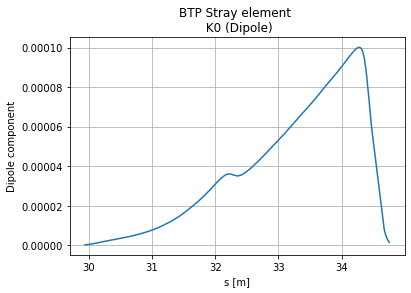

In [3]:
fig, ax = plt.subplots()
ax.plot(inner_merged["Position"], inner_merged["K0 (Dipole)"])

ax.set(xlabel='s [m]', ylabel='Dipole component',
       title='BTP Stray element \n K0 (Dipole)')

ax.grid()

### Theory from the MADX documentation on Sign Conventions for Magnetic Fields
http://madx.web.cern.ch/madx/releases/last-rel/madxuguide.pdf

#### For a straight section (curvature $h=0$), the field components can be computed as:


$$B_{x}(x,y) = B_{1}y + B_{2}xy + B_{3}\frac{1}{6}(3x^{2}y-y^3)$$

$$B_{y}(x,y) = B_{0} + B_{1}x + B_{2}\frac{1}{2}(x^{2}-y^{2}) + B_{3}\frac{1}{6}(x^{3}-3xy^{2})$$

where 

$$B_{0} = K0\cdot B\rho$$

$$B_{1} = K1\cdot B\rho$$

$$B_{2} = K2\cdot B\rho$$

$$B_{3} = K3\cdot B\rho$$


Choose a "dummy value" B_rho from a file that uses the btp element: general_bt1btp_lhc.madx

BEAM, PARTICLE=PROTON, PC = 2.794987;

BRHO := BEAM->PC * 3.3356;


In [22]:
B_rho= 2.794987*3.3356 # Dummy value for now. Doesn't change the shape, only scales the field.
inner_merged['B0'] = inner_merged['K0 (Dipole)'].apply(lambda x: x*B_rho)
inner_merged['B1'] = inner_merged['K1 (Quadrupole)'].apply(lambda x: x*B_rho)
inner_merged['B2'] = inner_merged['K2 (Sextupole)'].apply(lambda x: x*B_rho)
inner_merged['B3'] = inner_merged['K3 (Octupole)'].apply(lambda x: x*B_rho)
inner_merged.head(3)

Name   K0 (Dipole)  K1 (Quadrupole)  K2 (Sextupole)  K3 (Octupole)  \
0  stray1  2.110000e-07        -0.000003        0.000053      -0.001056   
1  stray2  2.780000e-07        -0.000004        0.000067      -0.001303   
2  stray3  3.540000e-07        -0.000005        0.000085      -0.001549   

    Position        B0        B1        B2        B3  
0  29.936061  0.000002 -0.000029  0.000489 -0.009845  
1  29.956061  0.000003 -0.000038  0.000628 -0.012149  
2  29.976061  0.000003 -0.000047  0.000790 -0.014437

In [23]:
s = inner_merged["Position"].to_numpy()
B0 = inner_merged["B0"].to_numpy()
B1 = inner_merged["B1"].to_numpy()
B2 = inner_merged["B1"].to_numpy()
B3 = inner_merged["B1"].to_numpy()
x = np.linspace(-10.0, 10.0, len(s)) # Dummy values for now
y = np.linspace(-10.0, 10.0, len(s)) # Dummy values for now

def bx_field_function(s, x, k0_on, k1_on, k2_on, k3_on):
    return B1*y*k1_on + B2*x*y*k2_on + B3*(1/6)*(3*x**2*y-y**3)*k3_on

def by_field_function(s, y, k0_on, k1_on, k2_on, k3_on):
    return B0*k0_on + B1*x*k1_on + B2*(1/2)*(x**2-y**2)*k2_on + B3*(1/6)*(x**3-3*x*y**2)*k3_on

S, X = np.meshgrid(s, x)
S, Y = np.meshgrid(s, y)

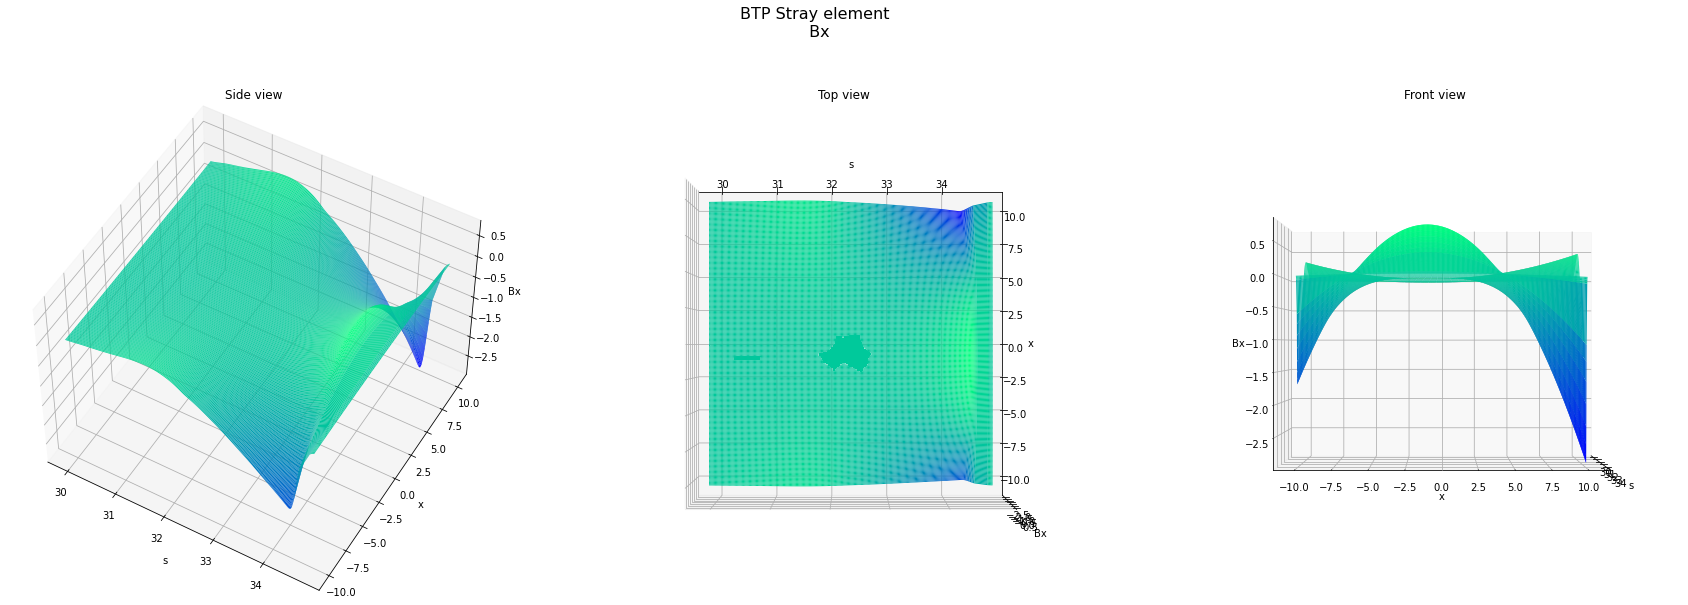

In [24]:
Bx = bx_field_function(S, X, 1, 1, 1, 1)

fig = plt.figure(figsize=[30,10])
fig.suptitle('BTP Stray element \n Bx', fontsize=16)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(S, X, Bx, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(50, 300)
ax.set_title('Side view')
ax.set_xlabel('s')
ax.set_ylabel('x')
ax.set_zlabel('Bx')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(S, X, Bx, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(90, 270)
ax.set_title('Top view')
ax.set_xlabel('s')
ax.set_ylabel('x')
ax.set_zlabel('Bx')

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(S, X, Bx, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(0, 360)
ax.set_title('Front view')
ax.set_xlabel('s')
ax.set_ylabel('x')
ax.set_zlabel('Bx')

plt.savefig("Bx.png",dpi=150)
plt.show()

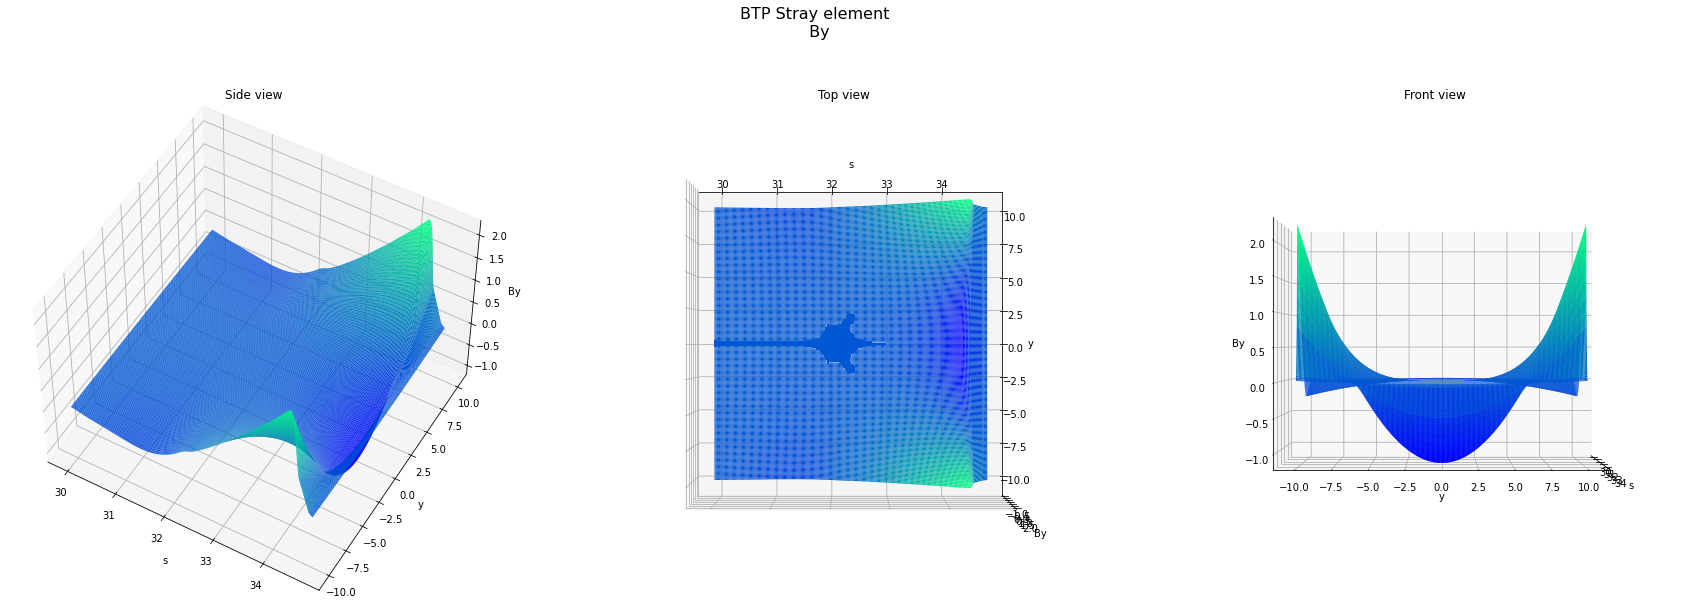

In [25]:
By = by_field_function(S, Y, 1, 1, 1, 1)

fig = plt.figure(figsize=[30,10])
fig.suptitle('BTP Stray element \n By', fontsize=16)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(S, Y, By, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(50, 300)
ax.set_title('Side view')
ax.set_xlabel('s')
ax.set_ylabel('y')
ax.set_zlabel('By')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(S, Y, By, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(90, 270)
ax.set_title('Top view')
ax.set_xlabel('s')
ax.set_ylabel('y')
ax.set_zlabel('By')

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(S, Y, By, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.view_init(0, 360)
ax.set_title('Front view')
ax.set_xlabel('s')
ax.set_ylabel('y')
ax.set_zlabel('By')

plt.savefig("By.png",dpi=150)
plt.show()